[3, 11, 24, 46, 38, 25]


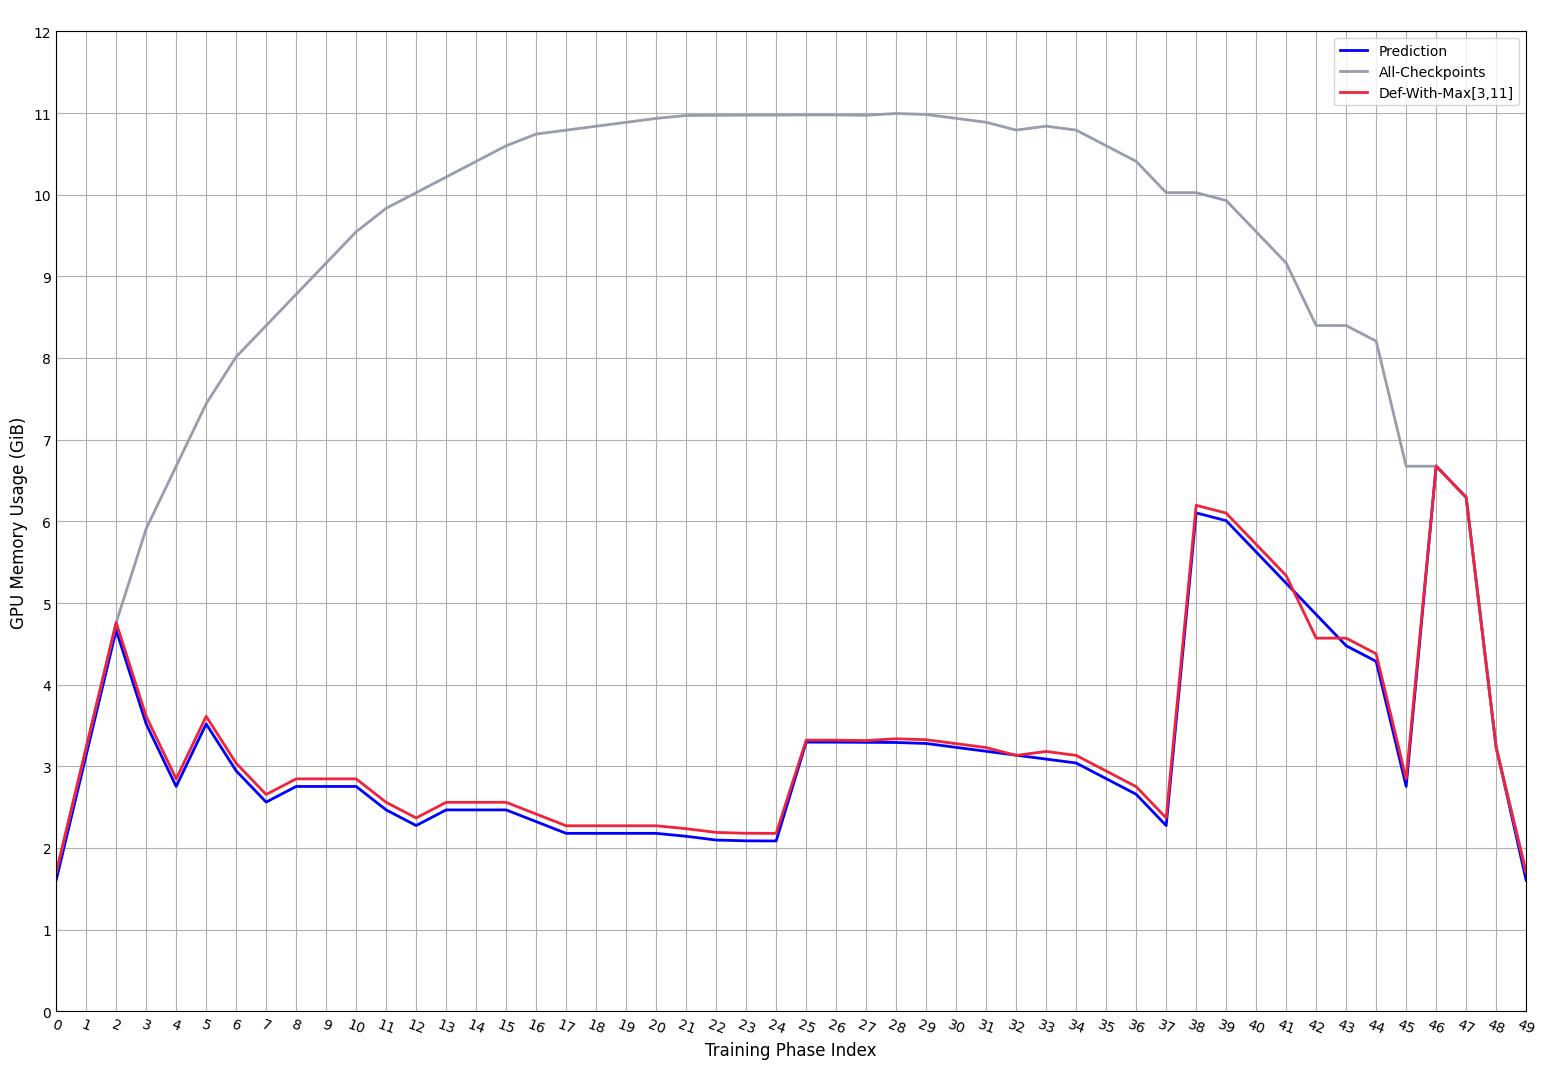

In [699]:
import matplotlib.pyplot as plt
import numpy as np
from tikzplotlib import save as tikz_save

plt.style.use('_mpl-gallery')

def get_tuple(tu):
    out = ''
    for t in tu:
        out = out + '{} {}\n'.format(t[0], t[1])
    return out.strip()


def read_ckpts():
    data = []
    with open('./checkpoints.txt', 'r') as file:
        data = file.read()

    return data


def tikzplotlib_fix_ncols(obj):
    """
    workaround for matplotlib 3.6 renamed legend's _ncol to _ncols, which breaks tikzplotlib
    """
    if hasattr(obj, "_ncols"):
        obj._ncol = obj._ncols
    for child in obj.get_children():
        tikzplotlib_fix_ncols(child)


#################################################
## in PyTorch
#################################################
def get_model_weight():
    # TODO: get from utils
    return 548

def get_wgm():
    # means weight, model, momentum
    return 3*get_model_weight()

def get_data_by_readfiles_forbackward(forward, backward):
    data_forw = []
    with open('./{}.txt'.format(forward), 'r') as file:
        for line in file:
            data_forw = data_forw + [ line ]    
    data_forw = data_forw[:28]
    data_forw = [ float(d.split(',')[-1].strip()) for d in data_forw ]
    
    data_back = []
    with open('./{}.txt'.format(backward), 'r') as file:
        for line in file:
            data_back = data_back + [ line ]
    data_back = [ float(d.split(',')[-1].strip()) for d in data_back ]
            
    return data_forw + data_back

def get_data_by_readfile(filename):
    data = []
    with open('./{}.txt'.format(filename), 'r') as file:
        for line in file:
            data = data + [ line ]
    data = [ float(d.split(',')[-1].strip()) for d in data ]
            
    return data
    

    
    
#################################################
## Hyper-Parameters.
#################################################
MARK_CHECKPOINTS = False
# y_display_max_GiB = 2
# total_training_phase = 24
# MODEL_NAME = 'alexnet'
MODEL_NAME = 'vgg19'
y_display_max_GiB = 12 # VGG=12, AlexNet=2
total_training_phase = 50 # VGG: 49 = 1 (front) + 23 (forward) + 24 (backward) + 1 (end); AlexNet: 18 or 24
#################################################

#################################################
## TODO: should generate this myself.
data_predicted = get_data_by_readfile('prediction')
data_predicted_GiB = [ d/1024 for d in data_predicted ] # algo-prediction.
# for i, v in enumerate(data_predicted_GiB):
#     print(i, v)
#################################################

#################################################
## Read datalines.
#################################################

data_no_grad_ckpt_GiB = [ d/1024 for d in get_data_by_readfile('no_checkpoint_{}'.format(MODEL_NAME)) ] # baseline.

# addional lines.
datalines_filename_pair = [
    # ('forward_{}_gc_chen_et_al'.format(MODEL_NAME), 'backward_{}_gc_chen_et_al'.format(MODEL_NAME)),
    # ('forward_{}_gc_chen_et_al_cp[5, 10, 15, 20]'.format(MODEL_NAME), 'backward_{}_gc_chen_et_al_cp[5, 10, 15, 20]'.format(MODEL_NAME)),
    ('forward_{}_gc_segment_cost_with_max'.format(MODEL_NAME), 'backward_{}_gc_segment_cost_with_max'.format(MODEL_NAME)),
]
datalines_to_draw = []
for name_pair in datalines_filename_pair:
    datalines_to_draw.append([ d/1024 for d in get_data_by_readfiles_forbackward(*name_pair) ])
#################################################


# plot
fig, ax = plt.subplots(figsize=(15,10))

# set {x,y}-axis.
ax.set(
    xlim=(0, total_training_phase-1), xticks=np.arange(total_training_phase),
    # TODO: change tick so that offset = ~500MB
    ylim=(0, y_display_max_GiB), yticks=np.arange(0, y_display_max_GiB+1)
)

# max_value = max(data_grad_ckpt_GiB)
# ax.axhline(y=max_value, color='red', label='Peak Mem.')

# draw title, label, legend.
ax.set(
    title=' ',
    ylabel='GPU Memory Usage (GiB)',
    xlabel='Training Phase Index',
)
ax.title.set_fontsize(12)
ax.xaxis.label.set_fontsize(12)
ax.yaxis.label.set_fontsize(12)
ax.set_yticks(np.arange(0, y_display_max_GiB+1))
ax.set_xticks(np.arange(0, total_training_phase))
ax.set_xlim(0, total_training_phase-1)
ax.set_ylim(0, y_display_max_GiB)
ax.tick_params(axis='x', rotation=-20, labelsize=10) # rotation to avoid x-lable overlapping.

ax.plot(np.arange(total_training_phase), data_predicted_GiB, linewidth=2.0, c='blue', label='Prediction')
ax.plot(np.arange(total_training_phase), data_no_grad_ckpt_GiB, linewidth=2.0, c='#979dac', label='All-Checkpoints')

# ax.plot(np.arange(total_training_phase), datalines_to_draw[0], linewidth=2.0, c='#0466c8', label='Def-Chen[3,6]')
# ax.plot(np.arange(total_training_phase), datalines_to_draw[1], linewidth=2.0, c='#5603ad', label='Def-Chen-$O(\sqrt{n})$ [5,10,15,20]')
ax.plot(np.arange(total_training_phase), datalines_to_draw[0], linewidth=2.0, c='#ef233c', label='Def-With-Max[3,11]')

ax.legend(loc='best')


tikzplotlib_fix_ncols(fig)


tikz_save('plot.tex')
fig.savefig('plot.png', bbox_inches='tight')

# read checkpoints.
checkpoints = [ int(c) for c in read_ckpts().split(',') ]
print(checkpoints)

line_index = 20 # DONT TOUCH THIS.
with open('./plot.tex', 'r') as file:
    lines = file.readlines()
total_lines = len(lines)

if MARK_CHECKPOINTS:
    # turn checkpoints into tuple by (x, profile_at(x)).
    test = [ (ckpt, data_grad_ckpt_GiB[ckpt])  for ckpt in checkpoints ]
    new_line3 = """\\addplot[scatter, only marks, scatter/classes={{
      gg={{mark=*,red}}
    }}] table[x=x, y=y] {{
    x y class
    {}
    }};
    """.format(get_tuple(test))
    lines.insert(total_lines-3, new_line3)

new_line1 = """ytick={{{}}},
xtick={{{}}},
xticklabel style={{rotate=340.0, font=\\tiny}},
legend style={{font=\\tiny}},
""".format(
    ','.join(map(str,np.arange(1, y_display_max_GiB+1))),
    ','.join(map(str,checkpoints))
) # The new line you want to insert
lines[line_index+1] = lines[line_index+1].strip() + ',\n'
lines.insert(line_index, new_line1)


with open('./plot.tex', 'w') as file:
    file.writelines(lines)

plt.show()